In [1]:
import numpy as np
import wisps
import wisps.simulations as wispsim
import pandas as pd
import splat
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import numba
from tqdm import tqdm
import splat.empirical as spem
import wisps.simulations.effective_numbers as ef 
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
import matplotlib as mpl
import splat.empirical as spe

%matplotlib inline

In [2]:
def custom_histogram(things, grid):
    n=[]
    for g in grid:
        n.append(len(things[np.logical_and(g<=things, things< g+1)]))
    return np.array(n)

def bin_by_spt_bin(sp_types, number):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def stay_within_limits(row):
    #print (row)
    flag=True
    if row.survey.lower()=='wisp':
        if ((row['F110W']>wisps.MAG_LIMITS['wisps']['F110W'][0]) or (row['F110W']<wisps.MAG_LIMITS['wisps']['F110W'][1])):
            flag=False
        if np.isnan(row['F110W']):
            flag=True
            
    if row.survey.lower()=='hst3d':
        if (row['F140W']>wisps.MAG_LIMITS['hst3d']['F140W'][0]) or (row['F140W']<wisps.MAG_LIMITS['hst3d']['F140W'][1]):
            flag=True
        if np.isnan(row['F140W']):
            flag=True
            
    if row.spt<17.:
        flag=False
    return flag

def selection_cuts(df):
    #make selection cuts in the simulated data
    flag_snr=(df.snr > 3.0).values
    flag0=  (df.appF140.between( wisps.MAG_LIMITS['hst3d']['F140W'][1], wisps.MAG_LIMITS['hst3d']['F140W'][0])).values 
    flag1=  (df.appF110.between( wisps.MAG_LIMITS['wisps']['F110W'][1], wisps.MAG_LIMITS['wisps']['F110W'][0])).values
    flag2=  (df.appF110.between( wisps.MAG_LIMITS['hst3d']['F160W'][1], wisps.MAG_LIMITS['hst3d']['F160W'][0])).values

    flag= np.logical_and.reduce((flag0, flag1, flag2, flag_snr))
    
    return df[flag]
    
    

In [3]:
SIMULATED_DIST=wispsim.simulate_spts()

data=ef.simulation_outputs()

MASSES=SIMULATED_DIST['mass']

In [4]:
drop_nan=ef.drop_nan

idx0=np.isnan(SIMULATED_DIST['teffs'])[0]

nan_masses=SIMULATED_DIST['mass'][idx0]
nan_ages=(SIMULATED_DIST['ages'][0])[idx0]

cmap= sns.cubehelix_palette(10, as_cmap=True)

cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf', key='with_indices')

In [5]:
def get_survey(grism_id):
    if grism_id.lower().startswith('par'):
        return 'wisp'
    else:
        return 'hst3d'

def get_mags(row):
    return pd.Series(row.spectra.mags)

In [6]:
mags_df=cands.apply(get_mags, axis=1)

In [7]:
tab=wisps.Annotator.reformat_table(cands.join(mags_df))
tab['survey']=tab['grism_id'].apply(get_survey)
flags=tab.apply(stay_within_limits, axis=1).values
cdf_to_use=tab[flags]
nobs=custom_histogram(cdf_to_use.spt.apply(wisps.make_spt_number), data['spgrid'])

In [8]:
spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
cnorm=Normalize(data['hs'][1], data['hs'][-2])

In [9]:
hs=data['hs']

In [10]:
def compute_simulated_numbers(hidx,selection='prob'):
    #an index in accordance with the scale height
    simdf=pd.DataFrame()
    nanidx=np.isnan(SIMULATED_DIST['spts'][0])
    simdf['spt']=wisps.drop_nan(SIMULATED_DIST['spts'][0])
    simdf['mass']=(SIMULATED_DIST['mass'])[~nanidx]
    
    if selection =='prob':
        simdf['slprob']=data['sl_prob'][hidx]
    
    if selection == 'uniform':
        simdf['slprob']=1.
        
    simdf['snr']=data['snrjs'][hidx]
    simdf['appF140']=data['appf140s'][hidx]
    simdf['appF110']=data['appf110s'][hidx]
    simdf['appF160']=data['appf160s'][hidx]
    cutdf=selection_cuts(simdf)
    NORM = 0.0055/ len(cutdf.mass[np.logical_and(cutdf.mass>=0.09, cutdf.mass <=0.1)])
    
    NSIM={}
    #rounded spectral type
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        NSIM[g[0]]=np.nansum((g[1]).slprob*NORM)
    return NSIM

In [13]:
hs

[200, 250, 275, 300, 325, 350, 1000]

7it [00:02,  3.22it/s]


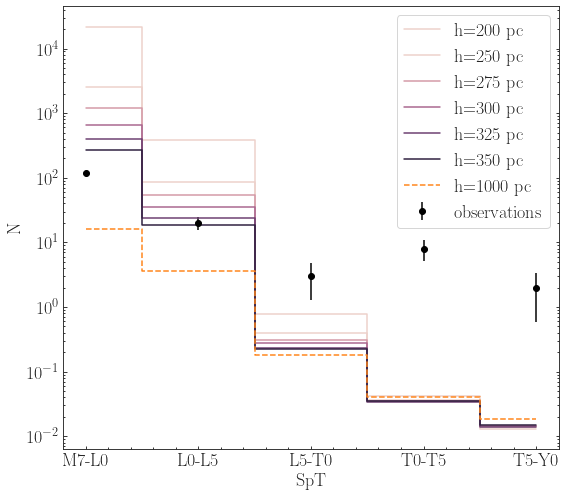

In [15]:
fig, ax1=plt.subplots(figsize=(8 , 7))

NS=[]
for idx, h in tqdm(enumerate(hs)):
    
    nsimulatedunif=compute_simulated_numbers(idx,selection = 'uniform')
    nsimulated=compute_simulated_numbers(idx)
    
    ns=[]
    nsunif=[]
    for s in data['spgrid']:
        try:
            ns.append(nsimulated[s])
            nsunif.append(nsimulatedunif[s])
        except:
            ns.append(np.nan)
            nsunif.append(np.nan)
        
    ns=np.array(ns)
    NS.append(ns)
    nsunif=np.array(nsunif)
    
    if hs[idx]==100:
        ax1.step(spgrid2, bin_by_spt_bin(data['spgrid'], ns*((data['vol'].T)[idx])), 
                 where='mid', label='h={} pc'.format(hs[idx]), color='#FF851B')
            
    elif hs[idx]==1000:
        ax1.step(spgrid2, bin_by_spt_bin(data['spgrid'], ns*((data['vol'].T)[idx])), 
                 where='mid', label='h={} pc'.format(hs[idx]), color='#FF851B', linestyle='--')
    else:
        ax1.step(spgrid2, bin_by_spt_bin(data['spgrid'], ns*((data['vol'].T)[idx])), 
                 where='mid', label='h={} pc'.format(hs[idx]), color=cmap(cnorm(hs[idx])))
        
    #ax1.step(spgrid2, bin_by_spt_bin(data['spgrid'], nsunif*((data['vol'].T)[idx])), 
    #             where='mid',  color='#AAAAAA')
        
    ax1.set_yscale('log')

y2=bin_by_spt_bin(data['spgrid'],nobs)
dy2=np.sqrt(y2)
ax1.errorbar(spgrid2,y2, yerr=dy2,
            label='observations',fmt='o', color='k')

ax1.set_xlabel('SpT',fontsize=18)
ax1.set_ylabel('N',fontsize=18)
ax1.legend(fontsize=18)

plt.minorticks_on()

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/oberved_numbers.pdf', bbox_inches='tight')


In [ ]:
snew=np.arange(17, 39)
sptidx=[i for i, spt in enumerate(data['spgrid']) if spt in snew]
VOLUMES=data['vol'].T

In [ ]:
sim_vs=pd.DataFrame(index=[splat.typeToNum(x).replace('.0', ' ') for x in (data['spgrid'])[sptidx]])
for hindex, h in enumerate(hs):
    numbaexcpected=data['n'][hindex]*(data['vol'].T)[hindex]*NORM
    sim_vs['volume {}'.format(h)]=np.round(VOLUMES[hindex])[sptidx]
    sim_vs['Number ex {}'.format(h)]=np.round(numbaexcpected, 1)[sptidx]
    sim_vs['Number ex {}'.format(h)]=(sim_vs['Number ex {}'.format(h)])[sptidx]
sim_vs['Number obs']=nobs[sptidx]

In [ ]:
sim_vs.loc["Total"] = sim_vs.sum()

In [ ]:
sim_vs

In [ ]:
sim_vs=sim_vs.reindex(sorted(sim_vs.columns), axis=1)

In [ ]:
len(sim_vs), sim_vs.shape

In [ ]:
sim_vs.to_latex(wisps.LIBRARIES+'/expectations.tex', index=True)